## Project prep
1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
    - cohort pulled from the sql table 
    - sort all the endpoints 
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
    - divided web dev and data science (4 different programs)
    - sort all the endpoints 
    - counts of cohorts accessing same endpoints
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
    - active status indicator 
    - filter by the student being active 
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
    - figure out what constitutes a suspicious IP address
        - any ip addresses from china?
        - figure out general area of ip address
    - how to recognize web scraping
    - SKIP 
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
    - how to classify the endpoints as web dev and not this might be crazy
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
    - active status indicator 
    - each row of a ping would have student_active column - Parker 
    - 
7. Which lessons are least accessed?
    - kind of related to 2
8. Anything else I should be aware of?

1 is related to 7 and 2 

3 is relate to 6

anything extra we find

### Data Frame Must Haves
- log data
- cohort data
- Join on cohort id (Left Join) - Lupe has the join and the drop columns 
- column that has the active student at time of request (yes or no)
- need key for all the program ids (is_data_science maybe) 
- endpoint as a web dev, or data science 
    - Anything came before ada's start date is webdev


In [1]:
# prepare file for anomaly detection exercises
import pandas as pd
import numpy as np

# Vis tools
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans 
from datetime import datetime
# defining some functions to make it easier. will go in Wrangle function
from env import host, password, user
import os
import prepare, acquire

In [2]:
###################### Getting database Url ################
def get_db_url(db_name, user=user, host=host, password=password):
    """
        This helper function takes as default the user host and password from the env file.
        You must input the database name. It returns the appropriate URL to use in connecting to a database.
    """
    url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
    return url

######################### get generic data #########################
def get_any_data(database, sql_query):
    '''
    put in the query and the database and get the data you need in a dataframe
    '''

    return pd.read_sql(sql_query, get_db_url(database))

In [3]:
def acquire_curriculum_logs(csv_name = "anonymized-curriculum-access-07-2021.txt"):
    '''
    This function reads the csv of curriculum access logs
    If the file name needs to be changed change the default arguement
    '''
    # assign column names to use
    colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
    # read csv
    df = pd.read_csv(csv_name, 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
    return df

def make_datetime_index(df, col_name):
    '''
    This function takes in a dataframe 
    A column name of the column that is your date (as string)
    Performs basic to_datetime conversion and sets tha column as the index
    '''
    
    df[col_name] = pd.to_datetime(df[col_name])

    df = df.set_index(col_name)
    
    return df

def prep(df):
    '''
    This function takes in the curriculum log data, and the user number you want to look at
    returns a dataframe of the pages they accessed and when
    '''
    #df = df[df.user_id == user]
    df = make_datetime_index(df, 'date')
    pages = df['endpoint'].resample('d').count()
    return pages

## Question 3 attempt

In [4]:
df = pd.read_csv('anonymized-curriculum-access.csv')

In [5]:
dbase = 'curriculum_logs'
sqlquery = 'SELECT * FROM cohorts'

cohorts = get_any_data(dbase, sqlquery)

In [6]:
log_df = df.merge(cohorts, how = 'left', left_on = 'cohort_id', right_on = 'id')

In [7]:
log_df.sample(50)

,Unnamed: 0,date,endpoint,user_id,cohort_id,source_ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
134685,134685,2018-10-03,mysql/basic-statements,226,25.0,97.105.19.58,25.0,Wrangell,#wrangell,2018-07-23,2018-11-29,2018-07-23 15:02:25,2018-07-23 15:02:25,None,2.0
920736,920736,2021-05-06,html-css/css-i/positioning,967,139.0,130.45.59.45,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
168403,168403,2018-12-10,javascript-i/loops,310,27.0,99.98.36.168,27.0,Yosemite,#yosemite,2018-11-05,2019-04-03,2018-11-05 15:26:37,2018-11-05 15:26:37,None,2.0
450419,450419,2020-02-06,spring/extra-features/file-upload,554,53.0,97.105.19.58,53.0,Fortuna,#fortuna,2020-01-13,2020-06-23,2020-01-13 21:17:08,2020-01-13 21:17:08,None,2.0
320080,320080,2019-08-13,mysql/tables,424,32.0,97.105.19.58,32.0,Betelgeuse,#betelgeuse,2019-05-28,2019-10-08,2019-05-28 18:41:05,2019-05-28 18:41:05,None,2.0
252557,252557,2019-04-24,java-iii/finish-the-adlister,329,29.0,97.105.19.58,29.0,Zion,#zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,None,2.0
542849,542849,2020-05-14,mysql,612,56.0,172.14.176.83,56.0,Apex,#apex,2020-02-24,2020-07-29,2020-02-24 15:39:33,2020-07-29 18:41:13,None,2.0
569180,569180,2020-06-10,appendix/capstone-workbook/sw-project-planning,502,28.0,99.76.234.122,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0
424112,424112,2020-01-07,jquery/events/mouse-events,528,52.0,97.105.19.58,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
981148,981148,2021-06-17,mysql/sample-database,630,28.0,24.160.140.11,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0


In [8]:
log_df = log_df.drop(columns = ['Unnamed: 0','slack','created_at','updated_at','deleted_at'])

In [9]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018810 entries, 0 to 1018809
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   date        1018810 non-null  object 
 1   endpoint    1018809 non-null  object 
 2   user_id     1018810 non-null  int64  
 3   cohort_id   965313 non-null   float64
 4   source_ip   1018810 non-null  object 
 5   id          954313 non-null   float64
 6   name        954313 non-null   object 
 7   start_date  954313 non-null   object 
 8   end_date    954313 non-null   object 
 9   program_id  954313 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 85.5+ MB


In [10]:
log_df = make_datetime_index(log_df,'date' )

In [11]:
log_df.isnull().value_counts()

endpoint  user_id  cohort_id  source_ip  id     name   start_date  end_date  program_id
False     False    False      False      False  False  False       False     False         954312
                   True       False      True   True   True        True      True           53497
                   False      False      True   True   True        True      True           11000
True      False    False      False      False  False  False       False     False              1
dtype: int64

In [12]:
log_df = log_df.dropna()

In [13]:
log_df.shape

(954312, 9)

In [14]:
log_df.start_date = pd.to_datetime(log_df.start_date.copy())

In [15]:
log_df.end_date = pd.to_datetime(log_df.end_date.copy())

In [16]:
log_df['is_active'] = (log_df.index >= log_df.start_date) & (log_df.index <= log_df.end_date)

In [17]:
log_df.sample(50)

,endpoint,user_id,cohort_id,source_ip,id,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,
2020-03-12,4-python/3-data-types-and-variables,581,55.0,97.105.19.58,55.0,Curie,2020-02-03,2020-07-07,3.0,True
2020-11-19,html-css/forms,791,132.0,72.181.149.13,132.0,Kalypso,2020-11-02,2021-05-04,2.0,True
2020-11-11,classification/scale_features_or_not.svg,695,59.0,162.197.239.66,59.0,Darden,2020-07-13,2021-01-12,3.0,True
2020-09-25,/,538,52.0,173.173.96.82,52.0,Europa,2019-11-04,2020-04-17,2.0,False
2021-04-03,javascript-i/arrays/manipulating,928,138.0,66.25.145.212,138.0,Neptune,2021-03-15,2021-09-03,2.0,True
2019-12-18,mysql/clauses,494,51.0,97.105.19.58,51.0,Deimos,2019-09-16,2020-02-27,2.0,True
2018-08-03,java-ii/collections,196,24.0,97.105.19.58,24.0,Voyageurs,2018-05-29,2018-10-11,2.0,True
2019-04-29,javascript-ii/npm,380,31.0,97.105.19.58,31.0,Andromeda,2019-03-18,2019-07-30,2.0,True
2021-01-28,toc,830,134.0,70.120.73.254,134.0,Luna,2020-12-07,2021-06-08,2.0,True


In [18]:
active_df = log_df[log_df.is_active == True]

In [19]:
active_df.groupby(by = 'user_id').sum()

,cohort_id,id,program_id,is_active
user_id,,,,
2,33902.0,33902.0,3082.0,1541
3,33308.0,33308.0,3028.0,1514
4,15224.0,15224.0,1384.0,692
5,35662.0,35662.0,3242.0,1621
6,28886.0,28886.0,2626.0,1313
...,...,...,...,...
991,122181.0,122181.0,1758.0,879
993,47260.0,47260.0,680.0,340
994,26966.0,26966.0,388.0,194


In [20]:
inactive_df = log_df[log_df.is_active == False]

In [21]:
(inactive_df[inactive_df['program_id'] == 3]).endpoint.value_counts().head(30)

/                                                                1782
search/search_index.json                                          649
classification/overview                                           368
sql/mysql-overview                                                343
classification/scale_features_or_not.svg                          325
anomaly-detection/AnomalyDetectionCartoon.jpeg                    226
anomaly-detection/overview                                        225
fundamentals/AI-ML-DL-timeline.jpg                                223
fundamentals/modern-data-scientist.jpg                            221
fundamentals/intro-to-data-science                                217
classification/classical_programming_vs_machine_learning.jpeg     187
1-fundamentals/modern-data-scientist.jpg                          130
1-fundamentals/AI-ML-DL-timeline.jpg                              129
1-fundamentals/1.1-intro-to-data-science                          129
classification/prep 

In [22]:
def active_status(df, start, end):
    df['is_active'] = (df.index >= df[start]) & (df.index <= df[end])
    return df

In [23]:
active_status(log_df, 'start_date', 'end_date')

,endpoint,user_id,cohort_id,source_ip,id,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
2021-07-15,toc,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0,True
2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0,True
2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,138.0,Neptune,2021-03-15,2021-09-03,2.0,True


In [24]:
def make_datetime(df, col_name, set_index = False):
    '''
    This function takes in a dataframe 
    A column name of the column that is your date (as string)
    Performs basic to_datetime conversion and sets tha column as the index
    '''
    if set_index == True:
        df[col_name] = pd.to_datetime(df[col_name])
        df = df.set_index(col_name)
        return df
    else:
        df[col_name] = pd.to_datetime(df[col_name])
    return df

In [25]:
make_datetime(log_df, 'start_date')

,endpoint,user_id,cohort_id,source_ip,id,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
2021-07-15,toc,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0,True
2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0,True
2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,138.0,Neptune,2021-03-15,2021-09-03,2.0,True


In [26]:
active_df['pings'] = 1

<ipython-input-26-d9354e190a6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_df['pings'] = 1


In [27]:
active_df.groupby(by = 'user_id').sum()

,cohort_id,id,program_id,is_active,pings
user_id,,,,,
2,33902.0,33902.0,3082.0,1541,1541
3,33308.0,33308.0,3028.0,1514,1514
4,15224.0,15224.0,1384.0,692,692
5,35662.0,35662.0,3242.0,1621,1621
6,28886.0,28886.0,2626.0,1313,1313
...,...,...,...,...,...
991,122181.0,122181.0,1758.0,879,879
993,47260.0,47260.0,680.0,340,340
994,26966.0,26966.0,388.0,194,194


In [28]:
active_users = active_df.groupby(by = 'user_id').sum()

In [29]:
active_users.describe().T

,count,mean,std,min,25%,50%,75%,max
cohort_id,741.0,60486.836707,60484.006240,57.0,21450.0,41856.0,78088.0,462434.0
id,741.0,60486.836707,60484.006240,57.0,21450.0,41856.0,78088.0,462434.0
program_id,741.0,2082.519568,1412.083426,2.0,1140.0,1899.0,2826.0,9672.0
is_active,741.0,968.415655,638.915976,1.0,536.0,901.0,1311.0,4786.0
pings,741.0,968.415655,638.915976,1.0,536.0,901.0,1311.0,4786.0


In [30]:
user_pings = pd.DataFrame(active_users['pings'])

In [31]:
user_pings

,pings
user_id,
2,1541
3,1514
4,692
5,1621
6,1313
...,...
991,879
993,340
994,194


In [32]:
log_df.describe()

,user_id,cohort_id,id,program_id
count,954312.000000,954312.000000,954312.000000,954312.000000
mean,498.817419,54.436431,54.436431,2.084774
std,274.303663,39.285234,39.285234,0.404666
min,1.000000,1.000000,1.000000,1.000000
25%,282.000000,28.000000,28.000000,2.000000
50%,509.000000,34.000000,34.000000,2.000000
75%,705.000000,59.000000,59.000000,2.000000
max,1082.000000,139.000000,139.000000,4.000000


In [33]:
cohorts = pd.read_csv('full_cohort_list.csv')

In [34]:
cohorts

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
5,6,Franklin,#franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
6,7,Glacier,#glacier,2015-06-05,2015-10-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
7,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
8,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4
9,10,Balboa,#balboa,2015-11-03,2016-03-11,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4


In [35]:
log_df = df.merge(cohorts, how = 'left', left_on = 'cohort_id', right_on = 'id')

In [36]:
log_df.value_counts().sum()

11000

In [37]:
log_df

,Unnamed: 0,date,endpoint,user_id,cohort_id,source_ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,0,2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,1,2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018805,1018805,2021-07-15,toc,925,138.0,24.26.246.133,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,NaN,2.0
1018806,1018806,2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,NaN,2.0
1018807,1018807,2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,NaN,2.0
1018808,1018808,2021-07-15,java-ii/object-oriented-programming,933,138.0,72.190.28.51,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,NaN,2.0


In [38]:
log_df = log_df.drop(columns = ['Unnamed: 0','slack','created_at','updated_at','deleted_at'])

In [39]:
log_df

,date,endpoint,user_id,cohort_id,source_ip,id,name,start_date,end_date,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
1018805,2021-07-15,toc,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0
1018806,2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0
1018807,2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,138.0,Neptune,2021-03-15,2021-09-03,2.0
1018808,2021-07-15,java-ii/object-oriented-programming,933,138.0,72.190.28.51,138.0,Neptune,2021-03-15,2021-09-03,2.0


In [40]:
log_df = make_datetime_index(log_df,'date' )

In [41]:
log_df

,endpoint,user_id,cohort_id,source_ip,id,name,start_date,end_date,program_id
date,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
2021-07-15,toc,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0
2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,138.0,Neptune,2021-03-15,2021-09-03,2.0
2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,138.0,Neptune,2021-03-15,2021-09-03,2.0


In [42]:
for x in log_df[['start_date','end_date']]:
    log_df = make_datetime(log_df, x)

In [43]:
log_df = prepare.active_status(log_df, log_df.index, 'start_date', 'end_date')

In [44]:
inactive_df = log_df[log_df.is_active == False]

In [45]:
active_df = log_df[log_df.is_active == True]

In [46]:
active_ping = active_df.groupby(by = 'user_id').sum()

In [47]:
active_ping.sort_values(by = 'is_active').head(50)

,cohort_id,id,program_id,is_active
user_id,,,,
918,138.0,138.0,2.0,1
879,135.0,135.0,2.0,1
619,57.0,57.0,2.0,1
940,138.0,138.0,2.0,1
832,186.0,186.0,6.0,3
278,96.0,96.0,8.0,4
539,260.0,260.0,10.0,5
956,834.0,834.0,12.0,6
812,406.0,406.0,14.0,7


In [48]:
active_ping

,cohort_id,id,program_id,is_active
user_id,,,,
2,33902.0,33902.0,3082.0,1541
3,33308.0,33308.0,3028.0,1514
4,15224.0,15224.0,1384.0,692
5,35662.0,35662.0,3242.0,1621
6,28886.0,28886.0,2626.0,1313
...,...,...,...,...
1076,15438.0,15438.0,186.0,93
1078,7304.0,7304.0,88.0,44
1079,9960.0,9960.0,120.0,60


# acquire use

In [49]:
log_df = acquire.get_joined_curriculum_data()

In [50]:
log_df

,date,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
1018805,2021-07-15,toc,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0
1018806,2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0
1018807,2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0
1018808,2021-07-15,java-ii/object-oriented-programming,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0


In [51]:
for x in log_df[['start_date','end_date']]:
    log_df = prepare.make_datetime(log_df, x)

In [52]:
log_df.dtypes

date                  object
endpoint              object
user_id                int64
cohort_id            float64
source_ip             object
name                  object
start_date    datetime64[ns]
end_date      datetime64[ns]
program_id           float64
dtype: object

In [53]:
log_df = prepare.make_datetime(log_df, 'date', set_index = True)

In [54]:
log_df

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...
2021-07-15,toc,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0
2021-07-15,java-iii/finish-the-adlister,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0
2021-07-15,java-ii/arrays,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0


In [55]:
log_df = prepare.active_status(log_df, log_df.index, 'start_date', 'end_date')

In [56]:
active_df = log_df[log_df['is_active'] == True]
inactive_df = log_df[log_df['is_active'] == False]

In [57]:
active_df.sample(10)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id,is_active
date,,,,,,,,,
2018-10-15,javascript-i/bom-and-dom/dom,276,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08,2.0,True
2019-09-19,java-i/control-statements-and-loops,445,33.0,97.105.19.58,Ceres,2019-07-15,2019-12-11,2.0,True
2018-08-16,/,195,24.0,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,2.0,True
2018-11-08,java-i,273,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08,2.0,True
2019-10-02,/,492,51.0,97.105.19.58,Deimos,2019-09-16,2020-02-27,2.0,True
2020-09-03,stats/hypothesis-testing-overview,694,59.0,96.8.130.152,Darden,2020-07-13,2021-01-12,3.0,True
2019-08-26,mysql,418,32.0,97.105.19.58,Betelgeuse,2019-05-28,2019-10-08,2.0,True
2018-10-10,javascript-i/bom-and-dom/dom-events,270,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08,2.0,True
2019-11-05,html-css/elements,530,52.0,192.171.117.210,Europa,2019-11-04,2020-04-17,2.0,True


In [58]:
active_counts = active_df.groupby(by = 'user_id').sum()

In [59]:
active_counts.is_active.describe()

count     796.000000
mean      915.322864
std       647.993850
min         1.000000
25%       461.000000
50%       839.500000
75%      1260.750000
max      4786.000000
Name: is_active, dtype: float64

In [60]:
active_counts.head()

,cohort_id,program_id,is_active
user_id,,,
2,33902.0,3082.0,1541
3,33308.0,3028.0,1514
4,15224.0,1384.0,692
5,35662.0,3242.0,1621
6,28886.0,2626.0,1313


In [61]:
lower_bound, upper_bound = prepare.get_lower_and_upper_bounds(active_counts.is_active)

/Users/parkervoit/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_active'>

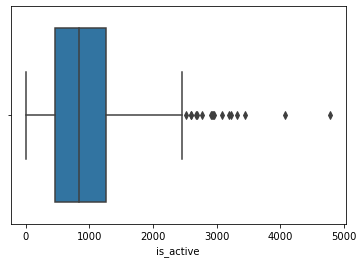

In [62]:
sns.boxplot(active_counts.is_active)

In [63]:
q1 = active_counts.is_active.quantile(0.25)
q3 = active_counts.is_active.quantile(0.75)
print(q1)
print(q3)

461.0
1260.75


In [64]:
 # then calculate iqr to calculate the upper/lower bounds
iqr = q3 - q1   
print(iqr)


799.75


In [65]:
multiplier = 1.5
print(round(q1 -(multiplier * iqr), 3))
print(round(q3 +(multiplier * iqr), 3))

-738.625
2460.375


In [66]:
1.5 * iqr

1199.625

<AxesSubplot:xlabel='is_active', ylabel='Count'>

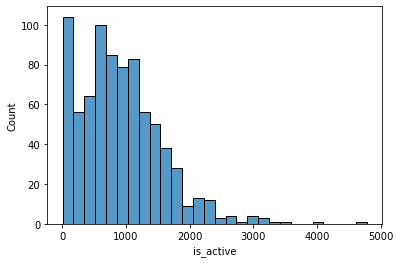

In [67]:
sns.histplot(active_counts.is_active)

In [68]:
active_counts.is_active.quantile(0.1)

122.5

In [69]:
low_ping = active_counts[active_counts['is_active'] <= active_counts.is_active.quantile(.1)]

In [70]:
low_ping.describe()

,cohort_id,program_id,is_active
count,80.000000,80.000000,80.000000
mean,4943.900000,111.762500,54.825000
std,5128.591865,74.187113,36.479498
min,57.000000,2.000000,1.000000
25%,1174.500000,48.500000,21.250000
50%,2533.000000,112.000000,56.000000
75%,8478.000000,174.500000,87.250000
max,18924.000000,276.000000,119.000000


### only pull active_counts[['active_ping','user_id']]

In [71]:
log_df = log_df.merge(active_counts, how = 'left', on = 'user_id')

In [72]:
log_df = log_df.drop(columns = ['cohort_id_y','program_id_y'])

In [73]:
log_df

,endpoint,user_id,cohort_id_x,source_ip,name,start_date,end_date,program_id_x,is_active_x,is_active_y
0,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
1,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
3,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
4,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True,1541.0
...,...,...,...,...,...,...,...,...,...,...
1018805,toc,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0,True,1116.0
1018806,java-iii/finish-the-adlister,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0,True,1116.0
1018807,java-ii/arrays,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0,True,662.0
1018808,java-ii/object-oriented-programming,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0,True,662.0


In [74]:
log_df = log_df.rename(columns = {'cohort_id_x':'cohort_id','program_id_x':'program_id','is_active_x':'is_active','is_active_y':'active_pings'})

In [75]:
log_df

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id,is_active,active_pings
0,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
1,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
3,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False,NaN
4,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True,1541.0
...,...,...,...,...,...,...,...,...,...,...
1018805,toc,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0,True,1116.0
1018806,java-iii/finish-the-adlister,925,138.0,24.26.246.133,Neptune,2021-03-15,2021-09-03,2.0,True,1116.0
1018807,java-ii/arrays,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0,True,662.0
1018808,java-ii/object-oriented-programming,933,138.0,72.190.28.51,Neptune,2021-03-15,2021-09-03,2.0,True,662.0


In [106]:
one_percentile = log_df[log_df['active_pings'] <= log_df.active_pings.quantile(.01)]

In [107]:
one_percentile.shape

(17341, 10)

In [108]:
log_og = acquire.get_joined_curriculum_data()

In [109]:
log_og.head()

,date,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [110]:
one_percentile = one_percentile.merge(log_og.date, how = 'left', left_index = True, right_index = True)

In [111]:
one_percentile = prepare.make_datetime(one_percentile, 'date', set_index = True)

In [112]:
one_percentile.sample(5)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id,is_active,active_pings
date,,,,,,,,,,
2019-09-10,spring/fundamentals/form-model-binding,64,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,False,25.0
2018-07-25,java-i/strings,64,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,False,25.0
2020-10-01,java-i/strings,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False,25.0
2020-10-23,/,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False,25.0
2019-06-05,mysql/relationships/sub-queries,64,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,False,25.0


In [114]:
lower_active_outliers = one_percentile[one_percentile['is_active'] == True]

In [115]:
lower_active_outliers

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id,is_active,active_pings
date,,,,,,,,,,
2018-01-26,spring,49,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2.0,True,25.0
2018-01-26,spring/fundamentals/controllers,49,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2.0,True,25.0
2018-01-26,spring/fundamentals/views,49,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2.0,True,25.0
2018-01-26,spring/fundamentals/services,49,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2.0,True,25.0
2018-01-26,spring/fundamentals/form-model-binding,49,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2.0,True,25.0
...,...,...,...,...,...,...,...,...,...,...
2021-07-13,javascript-i/testing-user-functions,1059,166.0,73.130.181.41,Draco,2021-06-28,2022-01-03,2.0,True,19.0
2021-07-14,javascript-i/loops,1059,166.0,73.130.181.41,Draco,2021-06-28,2022-01-03,2.0,True,19.0
2021-07-14,javascript-i/functions,1065,166.0,172.125.225.59,Draco,2021-06-28,2022-01-03,2.0,True,22.0


In [116]:
lower_active_outliers.describe()

,user_id,cohort_id,program_id,active_pings
count,257.000000,257.000000,257.000000,257.000000
mean,645.089494,89.793774,2.159533,16.322957
std,375.829546,58.268642,0.366887,6.296140
min,49.000000,21.000000,2.000000,1.000000
25%,340.000000,34.000000,2.000000,12.000000
50%,697.000000,59.000000,2.000000,16.000000
75%,1059.000000,166.000000,2.000000,22.000000
max,1068.000000,166.000000,3.000000,25.000000


In [123]:
lower_active_outliers.groupby(by = 'user_id').sum().sort_values(by = 'active_pings')

,cohort_id,program_id,is_active,active_pings
user_id,,,,
619,57.0,2.0,1,1.0
940,138.0,2.0,1,1.0
879,135.0,2.0,1,1.0
918,138.0,2.0,1,1.0
832,186.0,6.0,3,9.0
278,96.0,8.0,4,16.0
539,260.0,10.0,5,25.0
956,834.0,12.0,6,36.0
812,406.0,14.0,7,49.0


In [118]:
low_ping_users = lower_active_outliers.groupby(by = 'user_id').sum()

In [120]:
low_ping_users.shape

(23, 4)

In [122]:
lower_active_outliers.groupby(by = 'endpoint').sum().head(50)

,user_id,cohort_id,program_id,is_active,active_pings
endpoint,,,,,
/,20898,3274.0,79.0,38,593.0
1-fundamentals/1.1-intro-to-data-science,3431,295.0,15.0,5,59.0
1-fundamentals/1.2-data-science-pipeline,697,59.0,3.0,1,13.0
1-fundamentals/1.3-pipeline-demo,256,208.0,8.0,4,100.0
1-fundamentals/AI-ML-DL-timeline.jpg,3431,295.0,15.0,5,59.0
1-fundamentals/DataToAction_v2.jpg,697,59.0,3.0,1,13.0
1-fundamentals/modern-data-scientist.jpg,3431,295.0,15.0,5,59.0
13-advanced-topics/1-tidy-data,679,59.0,3.0,1,11.0
2-storytelling/3-tableau,697,59.0,3.0,1,13.0


In [124]:
lower_active_outliers.groupby(by = 'user_id').sum().sort_values(by = 'active_pings')

,cohort_id,program_id,is_active,active_pings
user_id,,,,
619,57.0,2.0,1,1.0
940,138.0,2.0,1,1.0
879,135.0,2.0,1,1.0
918,138.0,2.0,1,1.0
832,186.0,6.0,3,9.0
278,96.0,8.0,4,16.0
539,260.0,10.0,5,25.0
956,834.0,12.0,6,36.0
812,406.0,14.0,7,49.0


In [127]:
outlier_users = low_ping_users.index

In [145]:
d = {}
for x in outlier_users:
    d[x] = lower_active_outliers[lower_active_outliers['user_id'] == x]

In [151]:
d[49]['endpoint'].value_counts()

/                                                         3
spring/fundamentals/security                              3
spring/fundamentals/security/authentication               2
spring                                                    2
spring/fundamentals/relationships                         2
mysql/databases                                           2
spring/fundamentals/form-model-binding                    2
spring/extra-features                                     1
spring/fundamentals/repositories                          1
appendix/further-reading/spring/devtools-configuration    1
mysql/users                                               1
appendix/further-reading/spring/authorization             1
spring/fundamentals/views                                 1
spring/extra-features/form-validation                     1
spring/fundamentals/controllers                           1
spring/fundamentals/services                              1
Name: endpoint, dtype: int64

In [156]:
for x in outlier_users:
    print(d[x]['endpoint'].value_counts())

/                                                         3
spring/fundamentals/security                              3
spring/fundamentals/security/authentication               2
spring                                                    2
spring/fundamentals/relationships                         2
mysql/databases                                           2
spring/fundamentals/form-model-binding                    2
spring/extra-features                                     1
spring/fundamentals/repositories                          1
appendix/further-reading/spring/devtools-configuration    1
mysql/users                                               1
appendix/further-reading/spring/authorization             1
spring/fundamentals/views                                 1
spring/extra-features/form-validation                     1
spring/fundamentals/controllers                           1
spring/fundamentals/services                              1
Name: endpoint, dtype: int64
/          

In [158]:
d[49]['source_ip']

date
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-26    97.105.19.61
2018-01-29    97.105.19.61
2018-01-29    97.105.19.61
2018-01-29    97.105.19.61
2018-01-29    97.105.19.61
2018-01-29    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-01    97.105.19.61
2018-02-05    97.105.19.61
2018-02-05    97.105.19.61
Name: source_ip, dtype: object

In [159]:
for x in outlier_users:
    print(d[x]['source_ip'].value_counts())

97.105.19.61    25
Name: source_ip, dtype: int64
76.187.118.255    20
12.106.208.194     5
Name: source_ip, dtype: int64
107.77.217.9    3
97.105.19.58    1
Name: source_ip, dtype: int64
97.105.19.58     15
66.69.108.117     3
Name: source_ip, dtype: int64
97.105.19.58    8
Name: source_ip, dtype: int64
97.105.19.58    17
Name: source_ip, dtype: int64
97.105.19.58    5
Name: source_ip, dtype: int64
97.105.19.58    12
Name: source_ip, dtype: int64
97.105.19.58    1
Name: source_ip, dtype: int64
24.28.146.155    11
Name: source_ip, dtype: int64
136.50.70.27    13
Name: source_ip, dtype: int64
24.243.49.105    7
Name: source_ip, dtype: int64
69.154.52.98    3
Name: source_ip, dtype: int64
136.50.50.187    1
Name: source_ip, dtype: int64
98.156.147.200    16
Name: source_ip, dtype: int64
71.221.46.112    1
Name: source_ip, dtype: int64
70.121.129.79    1
Name: source_ip, dtype: int64
136.50.53.26    12
Name: source_ip, dtype: int64
162.200.114.251    6
Name: source_ip, dtype: int64
99.57.1

In [161]:
d[49].columns

Index(['endpoint', 'user_id', 'cohort_id', 'source_ip', 'name', 'start_date',
       'end_date', 'program_id', 'is_active', 'active_pings'],
      dtype='object')

In [163]:
for x in outlier_users:
    print(d[x]['name'].value_counts())

Sequoia    25
Name: name, dtype: int64
Europa    25
Name: name, dtype: int64
Voyageurs    4
Name: name, dtype: int64
Zion    18
Name: name, dtype: int64
Andromeda    8
Name: name, dtype: int64
Bayes    17
Name: name, dtype: int64
Europa    5
Name: name, dtype: int64
Fortuna    12
Name: name, dtype: int64
Ganymede    1
Name: name, dtype: int64
Darden    11
Name: name, dtype: int64
Darden    13
Name: name, dtype: int64
Hyperion    7
Name: name, dtype: int64
Jupiter    3
Name: name, dtype: int64
Marco    1
Name: name, dtype: int64
Marco    16
Name: name, dtype: int64
Neptune    1
Name: name, dtype: int64
Neptune    1
Name: name, dtype: int64
Neptune    12
Name: name, dtype: int64
Oberon    6
Name: name, dtype: int64
 Draco       19
Name: name, dtype: int64
 Draco       15
Name: name, dtype: int64
 Draco       22
Name: name, dtype: int64
 Draco       15
Name: name, dtype: int64


In [187]:
print(outlier_users)
for x in outlier_users:
    print(d[x][['program_id', 'start_date', 'user_id', 'endpoint']])

Int64Index([  49,   64,  278,  340,  388,  487,  539,  572,  619,  679,  697,
             812,  832,  879,  889,  918,  940,  941,  956, 1059, 1060, 1065,
            1068],
           dtype='int64', name='user_id')
            program_id start_date  user_id  \
date                                         
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-26         2.0 2017-09-27       49   
2018-01-29         2.0 2017-09-27       49   
2018-01-29         2.0 2017-09-27       49   
2018-01-29         2.0 2017-09-27       49   
2018-01-29         2.0 2017-09-27       49   
2018-01-29         2.0 2017-09-27       49   
2018-02-01         2.0 2017-09-27       49   
2

In [185]:
list(d.keys())[0]

49

In [186]:
d

{49:                                                      endpoint  user_id  \
 date                                                                     
 2018-01-26                                             spring       49   
 2018-01-26                    spring/fundamentals/controllers       49   
 2018-01-26                          spring/fundamentals/views       49   
 2018-01-26                       spring/fundamentals/services       49   
 2018-01-26             spring/fundamentals/form-model-binding       49   
 2018-01-26                   spring/fundamentals/repositories       49   
 2018-01-26                  spring/fundamentals/relationships       49   
 2018-01-26                       spring/fundamentals/security       49   
 2018-01-26                                             spring       49   
 2018-01-29                                                  /       49   
 2018-01-29                                    mysql/databases       49   
 2018-01-29          

# takeaways 